# Fourier Transformation and Power Spectrum

Import Libraries

In [7]:
# Import libraries
import os
import random
import glob
import sys
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import scipy
import scipy.stats as stats

sys.path.append(os.path.abspath('./../../sdo_augmentation/'))
from augmentation_test import read_image
from augmentation_list import AugmentationList
from augmentation import Augmentations

Load random EUV pickle splice image and display it

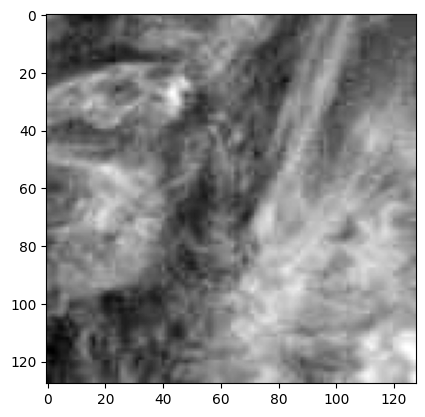

In [57]:
# Collect all pickle files and select a random one
image_paths = glob.glob('./HITS-SDO-Independent-Research/AIA171_Miniset_BW/**/*.jpg', recursive = True)
image_path = random.choice(image_paths)

# Read image
image = np.array(Image.open(image_path).convert('L'))
image = image.astype(float) / 255
# Show image
plt.imshow(image, cmap = 'gray')
plt.show()

Perform random set of augmentations

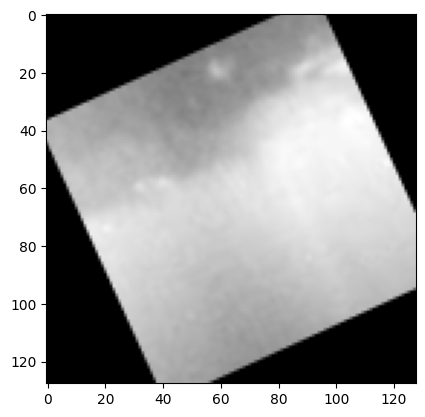

In [9]:
augmentation_list = AugmentationList('euv')
augmentation = Augmentations(image, augmentation_list.randomize())
augmented_image, _ = augmentation.perform_augmentations()

plt.imshow(augmented_image, cmap = 'gray')
plt.show()

Apply Fast Fourier on Augmented Image, and get its amplitude and phase

C:\Users\starf\AppData\Local\Temp\ipykernel_15416\630602218.py:9: RuntimeWarning: divide by zero encountered in log
  axs[1].plot(np.log(fourier_augmented_phases.flatten()))
C:\Users\starf\AppData\Local\Temp\ipykernel_15416\630602218.py:9: RuntimeWarning: invalid value encountered in log
  axs[1].plot(np.log(fourier_augmented_phases.flatten()))


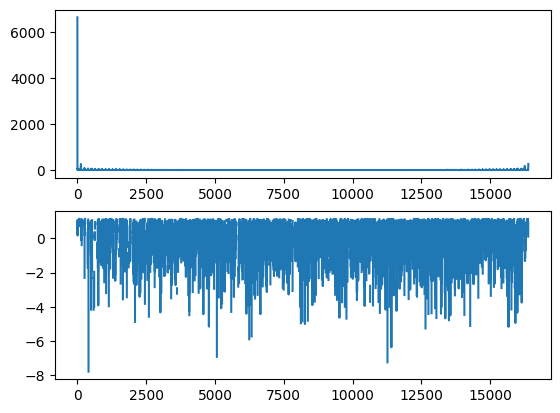

In [58]:
fig, axs = plt.subplots(2)

# Fast fourier for augmented image
fourier_augmented_image = np.fft.fftn(image)
fourier_augmented_amplitudes = np.abs(fourier_augmented_image)
fourier_augmented_phases = np.angle(fourier_augmented_image)

axs[0].plot(fourier_augmented_amplitudes.flatten())
axs[1].plot(np.log(fourier_augmented_phases.flatten()))

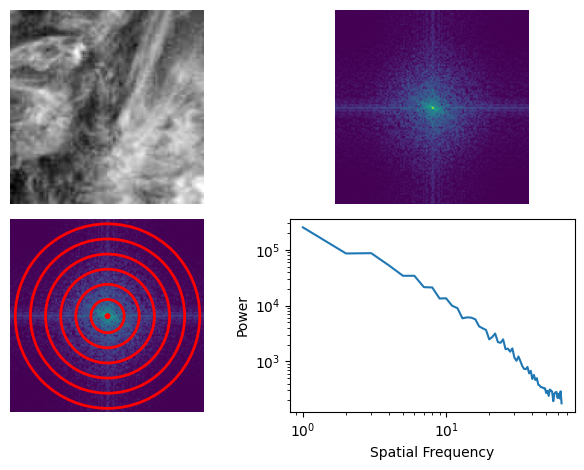

In [76]:
from scipy.fft import fft2, fftshift
from scipy.signal import detrend
from matplotlib.patches import Circle

pixel_count = image.shape[0]
k_frequencies = np.fft.fftfreq(pixel_count) * pixel_count
k_frequencies2D = np.meshgrid(k_frequencies, k_frequencies)
k_norm = np.sqrt(k_frequencies2D[0] ** 2 + k_frequencies2D[1] ** 2)
k_bins = np.arange(0.5, pixel_count // 2 + 1, 1.)
k_vals = 0.5 * (k_bins[1:] + k_bins[:-1])
# Create power spectrum
a_bins, _, _ = stats.binned_statistic(k_norm.flatten(),
                                     (fourier_augmented_amplitudes ** 2).flatten(),
                                     statistic = "mean", bins = k_bins)
a_bins *= np.pi * (k_bins[1:] ** 2 - k_bins[:-1] ** 2)


circle_params = []

for i in range(1, 65, 10):  # Create 10 circles as an example
    circle_params.append({'center': (pixel_count // 2, pixel_count // 2), 'radius': i})

fig, ax = plt.subplots(2,2)

# Add circles to the image
for params in circle_params:
    circle = Circle(params['center'], params['radius'], fill=False, color='red', linewidth=2)
    ax[1][0].add_patch(circle)


# Perform 2D Fourier Transform
fourier_image = fft2(image)

# Calculate the 2D power spectrum
power_spectrum = np.abs(fourier_image) ** 2

# Shift the zero frequency components to the center
power_spectrum = fftshift(power_spectrum)

ax[0][0].axis('off')  # Remove axis numbers
ax[0][1].axis('off')  # Remove axis numbers
ax[1][0].axis('off')  # Remove axis numbers



# Apply a custom colormap and adjust the color scaling
ax[0][0].imshow(image, cmap='gray')
ax[0][1].imshow(np.log10(power_spectrum + 1), cmap='viridis')
ax[1][0].imshow(np.log10(power_spectrum + 1), cmap='viridis')
ax[1][1].set_xlabel('Spatial Frequency')
ax[1][1].set_ylabel('Power')
ax[1][1].loglog(k_vals, a_bins)

fig.gca().set_frame_on(True)
plt.tight_layout()
plt.show()



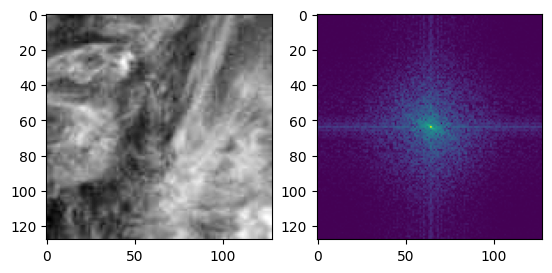

In [60]:
fig, ax = plt.subplots(1,2)
ax[0].imshow(image, cmap='gray')
ax[1].imshow(np.log10(power_spectrum + 1), cmap='viridis')
plt.show()

Create the 1D power spectrum of the Fourier Image

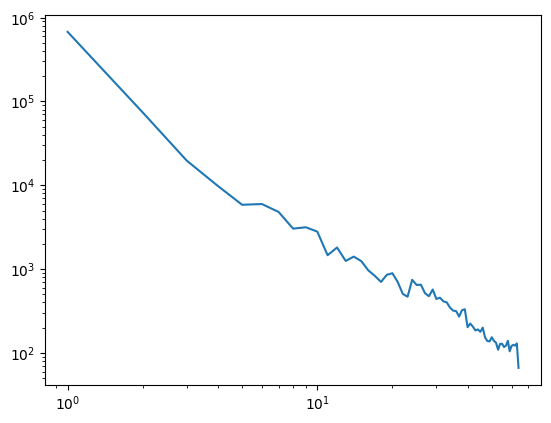

In [24]:
pixel_count = image.shape[0]

# Calculate k values
k_frequencies = np.fft.fftfreq(pixel_count) * pixel_count
k_frequencies2D = np.meshgrid(k_frequencies, k_frequencies)
k_norm = np.sqrt(k_frequencies2D[0] ** 2 + k_frequencies2D[1] ** 2)
k_bins = np.arange(0.5, pixel_count // 2 + 1, 1.)
k_vals = 0.5 * (k_bins[1:] + k_bins[:-1])

# Create power spectrum
a_bins, _, _ = stats.binned_statistic(k_norm.flatten(),
                                     (fourier_augmented_amplitudes ** 2).flatten(),
                                     statistic = "mean", bins = k_bins)
a_bins *= np.pi * (k_bins[1:] ** 2 - k_bins[:-1] ** 2)

# Plot power spectrum
plt.loglog(k_vals, a_bins)


In [25]:
print(k_bins)

[ 0.5  1.5  2.5  3.5  4.5  5.5  6.5  7.5  8.5  9.5 10.5 11.5 12.5 13.5
 14.5 15.5 16.5 17.5 18.5 19.5 20.5 21.5 22.5 23.5 24.5 25.5 26.5 27.5
 28.5 29.5 30.5 31.5 32.5 33.5 34.5 35.5 36.5 37.5 38.5 39.5 40.5 41.5
 42.5 43.5 44.5 45.5 46.5 47.5 48.5 49.5 50.5 51.5 52.5 53.5 54.5 55.5
 56.5 57.5 58.5 59.5 60.5 61.5 62.5 63.5 64.5]


Convert image in fourier space back to normal image